In [1]:
import json
import os
from os.path import join
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.plotting import aligned_imshow_cbar
from nilearn.input_data import NiftiSpheresMasker
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from dn_utils.networks import zscore_network

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_root = os.environ.get('DECIDENET_PATH')

path_derivatives = join(path_root, 'data/main_fmri_study/derivatives') 
path_sourcedata = join(path_root, 'data/main_fmri_study/sourcedata') 

path_beh = join(path_sourcedata, 'behavioral')
path_bsc = join(path_derivatives, 'bsc')
path_parcellations = join(path_derivatives, 'parcellations')
path_data_paths = join(path_derivatives, 'data_paths')
path_nistats = join(path_derivatives, 'nistats')

path_betamaps = join(path_bsc, 'betamaps')
path_betaseries = join(path_bsc, 'betaseries')
path_exclusion_csv = join(path_nistats, 'exclusion/exclusion.csv')

Path(path_betaseries).mkdir(exist_ok=True)

In [5]:
atlas = 'meta_roi'

# Load ROI data
df_roi = pd.read_csv(join(path_parcellations, atlas, f'{atlas}_table.csv'))
df_roi = df_roi.drop(19)

n_rois = len(df_roi)
n_perr_sign = 2

# Load behavioral data
beh, meta = load_behavioral_data(path_beh, verbose=False)
n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]

# Load betaseries
betaseries_aggregated = np.load(join(path_betaseries, atlas, 
                                     'betaseries_aggregated.npy'))

# Load exclusion table
df_exclusion = pd.read_csv(path_exclusion_csv, index_col=0)
ok_index = df_exclusion.index[df_exclusion['ok_all']]

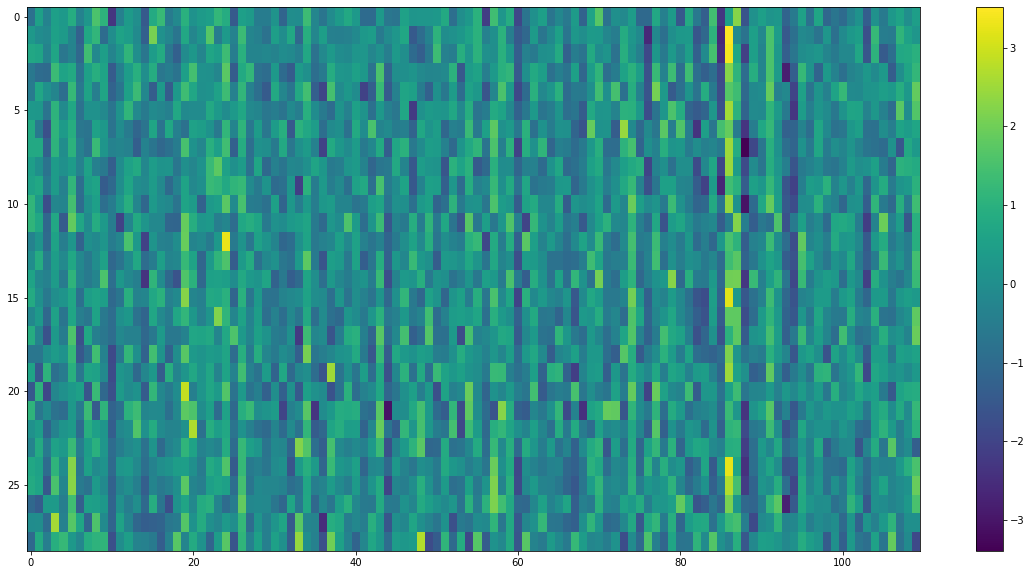

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
im = ax.imshow(betaseries_aggregated[0,0].T, aspect='auto', interpolation='none')
plt.colorbar(im)

In [ ]:
mats = np.zeros((n_subjects, n_conditions, n_perr_sign, n_rois, n_rois))

for sub_idx, sub in enumerate(meta['dim1']):
    for con_idx, con in enumerate(meta['dim2']):
        
        betaseries = betaseries_aggregated[sub_idx, con_idx]
        
        won_bool_idx = meta['dim4'].index('won_bool')
        won_bool = beh[sub_idx, con_idx, :, won_bool_idx].astype(bool)
        
        # Calculate BSC networks
        #mats[sub_idx, con_idx, 0] = zscore_network(np.corrcoef(betaseries[won_bool, :].T))
        #mats[sub_idx, con_idx, 1] = zscore_network(np.corrcoef(betaseries[~won_bool, :].T))
        mats[sub_idx, con_idx, 0] = np.corrcoef(betaseries[won_bool, :].T)
        mats[sub_idx, con_idx, 1] = np.corrcoef(betaseries[~won_bool, :].T)

In [ ]:
plt.imshow(mats[0,1,1], clim=[-3, 3], cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [ ]:
mats_submean = np.mean(mats[ok_index], 0)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for con_idx, con in enumerate(meta['dim2']):
    for perr_sign_idx, perr_sign in enumerate(['pos', 'neg']):
        ax = axs[con_idx][perr_sign_idx]
        im = ax.imshow(
            mats_submean[con_idx, perr_sign_idx],
            clim=(-3, 3),
            cmap='RdBu_r',
        )
        ax.set_title(f'Condition {con} | PE: {perr_sign}')
        aligned_imshow_cbar(ax, im)
        
plt.tight_layout()

In [ ]:
nets_diff = np.zeros((n_subjects, n_conditions, 2, 2))
mats_diff = mats[:, :, 0, :, :] - mats[:, :, 1, :, :]

network_names = ['perr_inc', 'perr_dec']

for i, net_i in enumerate(network_names):
    for j, net_j in enumerate(network_names):
        net_i_idx = df_roi[df_roi['netName'] == net_i].index
        net_j_idx = df_roi[df_roi['netName'] == net_j].index
        nets_diff[:, :, i, j] = np.nanmean(
            mats_diff[:, :, net_i_idx, :][:, :, :, net_j_idx], 
            axis=(-1, -2))

In [ ]:
plt.imshow(np.nanmean(mats_diff[ok_index, 0], axis=0), clim=[-1, 1], cmap='RdBu_r')
plt.show()
plt.imshow(np.nanmean(mats_diff[ok_index, 1], axis=0), clim=[-1, 1], cmap='RdBu_r')
plt.show()

In [ ]:
data = []
nets_dict = {'↑pe': (0, 0), '↓pe': (1, 1)}

for sub, sub_name in enumerate(df_exclusion.loc[ok_index, 'sub']):
    for con, con_name in enumerate(meta['dim2']):
        for net, netidx in nets_dict.items():
            data.append(
                [
                    nets_diff[sub, con, netidx[0], netidx[1]],
                    sub_name,
                    con_name,
                    net
                ]
            )

df = pd.DataFrame(data, columns=['connectivity', 'sub_name', 'condition', 'net'])
            
# Two-way ANOVA
model = ols('connectivity ~ C(condition) + C(net) + C(condition):C(net)', data=df).fit()
df_anova = sm.stats.anova_lm(model, typ=2)

# Figure 
fig, ax = plt.subplots(figsize=(5, 4))
bp = sns.barplot(
    x='condition', 
    y='connectivity', 
    hue='net',
    data=df,
    ax=ax,
    palette={'↑pe': '#f49915', '↓pe': '#5E88CA', 'int': 'gray'}
)
plt.legend(loc='upper right')

df_anova